In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import PolynomialFeatures
import datetime 
import pytz
from pytz import timezone
import tarfile
from numpy import load
import os
from sklearn.manifold import TSNE
import h5py
from sklearn.decomposition import PCA as sklearnPCA
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
import scipy as sp
from scipy import spatial
from scipy import stats

In [190]:
h5 = h5py.File('sound_data_improved.hdf5', 'r')

In [191]:
d = h5['sound_data']

# Create a subsample of 10000 points from one sensor

Filter for sensor id (sonycnode-b827ebc178d2.sonyc first, just to test)

In [192]:
# b827ebc178d2_mask = (d['sensor_id'] == b'sonycnode-b827ebc178d2.sonyc')

In [193]:
# b827ebc178d2_data = d[b827ebc178d2_mask]

In [194]:
# b827ebc178d2_indices = np.nonzero(b827ebc178d2_mask)[0]

In [199]:
b827ebc178d2_sample_nums = np.random.choice(range(len(b827ebc178d2_data)), 10000, replace = False)

In [241]:
# index = np.zeros(len(b827ebc178d2_data)).astype('bool')
# index[b827ebc178d2_sample_nums] = True

In [252]:
def get_sensor_mask(sensor_name, target_arr):
    """
    Returns a mask to apply on an array of data from different sensors. The mask filters out the data from one sensor.
    
    Parameters
    ----------
    sensor_name : String
        The name of the sensor to retrieve the data for, should take the form of b'sonycnode-[name].sonyc'
    
    target_arr : array of Strings
        Array containing the names of all the sensors.
        
    Returns
    -------
    sensor_mask : boolean array
        A boolean array of the same shape as target_arr, with True values corresponding to the indices containing the
        sensor_name.
    """
    sensor_mask = (target_arr == sensor_name)
    return sensor_mask

In [253]:
b827ebc178d2_mask = get_sensor_mask(d['sensor_id'], b'sonycnode-b827ebc178d2.sonyc')

In [201]:
# b827ebc178d2_sampled_data = b827ebc178d2_data[index]['feature_vector']

# Creating subsample of 10000 points from all four sensors

In [202]:
d.shape[0]

3388858

In [203]:
sample_nums = np.random.choice(range(d.shape[0]), 10000, replace = False)

In [204]:
d.shape

(3388858,)

In [256]:
index = np.zeros(d.shape[0]).astype('bool')
index[sample_nums] = True

In [206]:
# sensor_data = d[all_index]['feature_vector']

In [207]:
# sensor_data.shape

(10000, 512)

# Clustering on 45 dimensions

In [208]:
pca_45 = sklearnPCA(45)
projected_45 = pca_45.fit_transform(d['feature_vector'])

In [258]:
def get_cluster_assignments(num_clusters, sensor_transformed, fit_arr):
    """
    Returns an array containing the number of each cluster each data point in sensor_transformed is assigned to.
    Clustering is performed using MiniBatchKMeans.
    
    Parameters
    ----------
    num_clusters : int
        The number of clusters to group sensor_transformed into.
        
    sensor_transformed : array of floats
        45-dimensional array of feature vectors from one sensor 
        
    fit_arr : array of floats
        45-dimensional array of feature vectors from all sensors
    """
    mbk = MiniBatchKMeans(n_clusters=num_clusters, random_state=0)
    mbk.fit(fit_arr)
    cluster_indices = mbk.predict(sensor_transformed)
    return cluster_indices

Converts timestamps for each sensor into datetime format

In [231]:
def convert_timestamps(sensor_timestamps):
    """
    Fills a new array with the number of the day in June of each timestamp value of the array that is passed in.
    
    Parameters
    ----------
    sensor_timestamps : array of floats
        An array containing timestamps in float form.
        
    Returns
    -------
    sensor_timestamps_dt : datetime array
        numpy array of the same size as sensor_timestamps with dtype=datetime.datetime, containing day values for each
        timestamp.
    """
    sensor_timestamps_dt = np.empty(sensor_timestamps.shape[0], dtype = datetime.datetime)
    for i in range(sensor_timestamps.shape[0]):
        j = sensor_timestamps[i]
        dt = datetime.datetime.utcfromtimestamp(j)
        dt = pytz.UTC.localize(dt)
        #only fills in the day because we know it's all in June
        dt = dt.astimezone(pytz.timezone('US/Eastern')).day
        sensor_timestamps_dt[i] = dt
        
    return sensor_timestamps_dt

In [254]:
b827ebc178d2_transformed = projected_45[b827ebc178d2_mask]

In [245]:
b827ebc178d2_timestamps = d[b827ebc178d2_mask, 'timestamp']
b827ebc178d2_timestamps_dt = convert_timestamps(b827ebc178d2_timestamps)

In [261]:
test = get_cluster_assignments(7, b827ebc178d2_transformed, projected_45[index])

Plot timestamp vs frequency of cluster (for each cluster)

In [282]:
def plot_clusters(num_clusters, sensor_transformed, fit_arr, sensor_timestamps_dt):
    """
    Plots a histogram of the frequency of cluster assignments over time for one sensor.
    
    Parameters
    ----------
    num_clusters : int
        The number of clusters to assign the data to.
        
    sensor_transformed : 45-dimensional array of floats
        An array taken from projected_45 with only the feature vectors corresponding to one sensor.
        
    fit_arr : array of floats
        45-dimensional array of feature vectors from all sensors
        
    sensor_timestamps_dt : datetime array
        numpy array with dtype=datetime.datetime, containing day values for each data point gathered for a specified
        sensor.
    """
    plt.figure(figsize=(15, 15))
    subplot_idx = 1
    test = get_cluster_assignments(num_clusters, sensor_transformed, fit_arr)
    for cluster_num in range(num_clusters):
        cluster_mask = np.nonzero(test==cluster_num)
        timestamp_arr = sensor_timestamps_dt[cluster_mask]
        plt.subplot(3, 3, subplot_idx)
        plt.hist(timestamp_arr, bins=30)
        plt.title('cluster number ' + str(cluster_num))
        axes = plt.gca()
        axes.set_ylim([0,20000])
    #     plt.plot(timestamp_arr, test[cluster_mask])
        subplot_idx += 1
    plt.show()

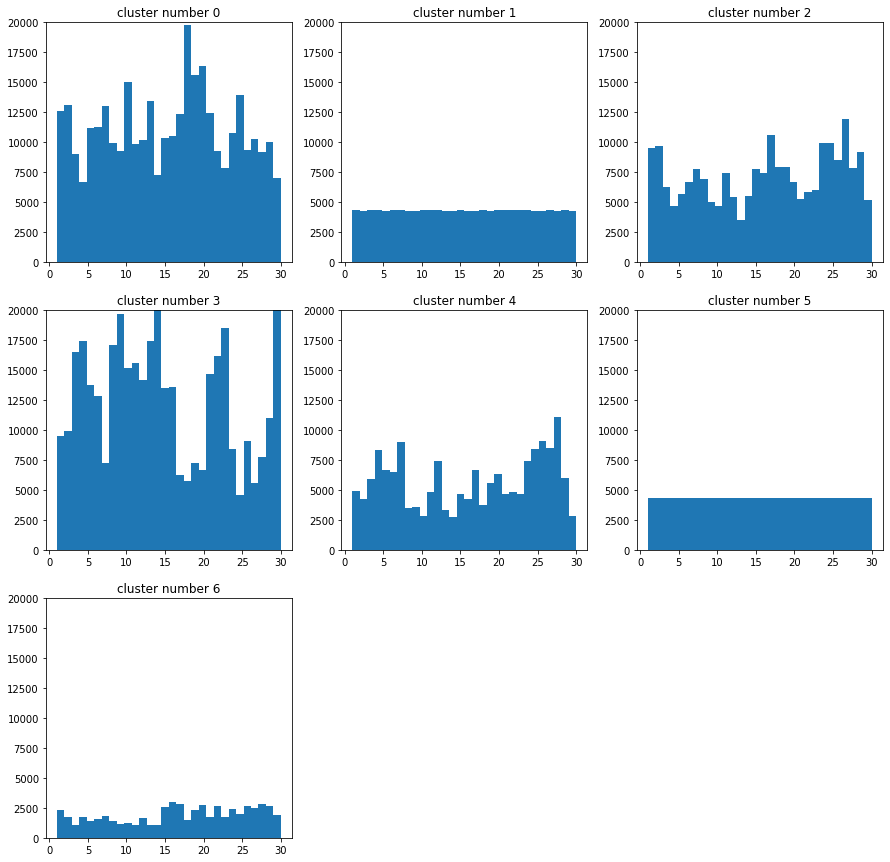

In [283]:
plot_clusters(7, b827ebc178d2_transformed, projected_45[index], b827ebc178d2_timestamps_dt)

b'sonycnode-b827eb491436.sonyc'


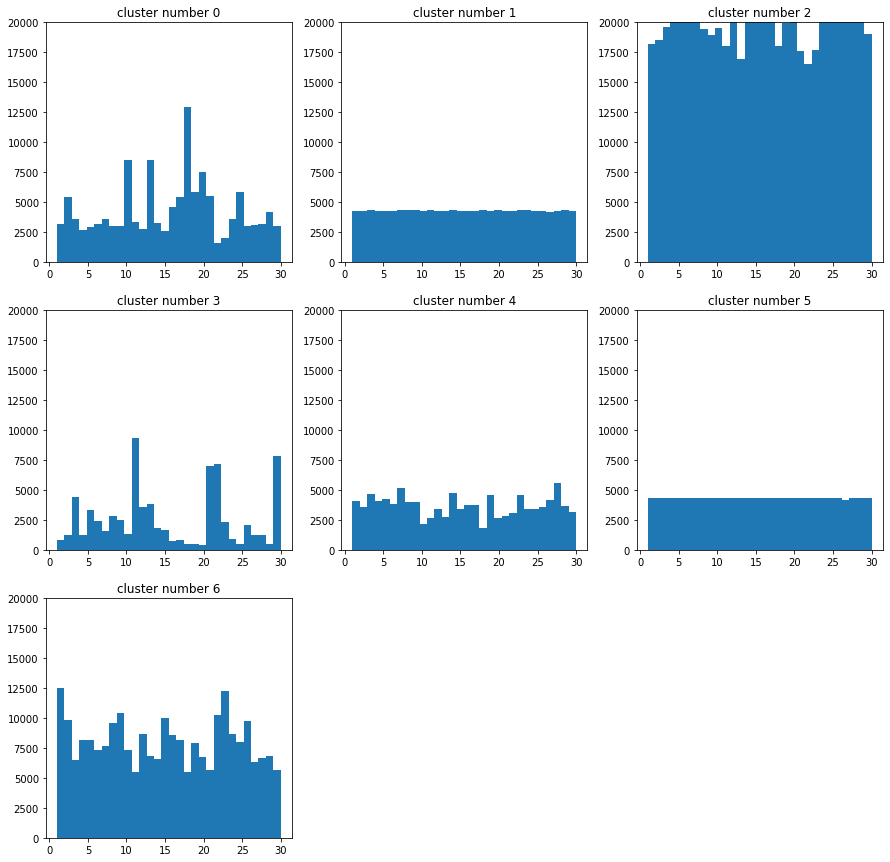

b'sonycnode-b827ebc178d2.sonyc'


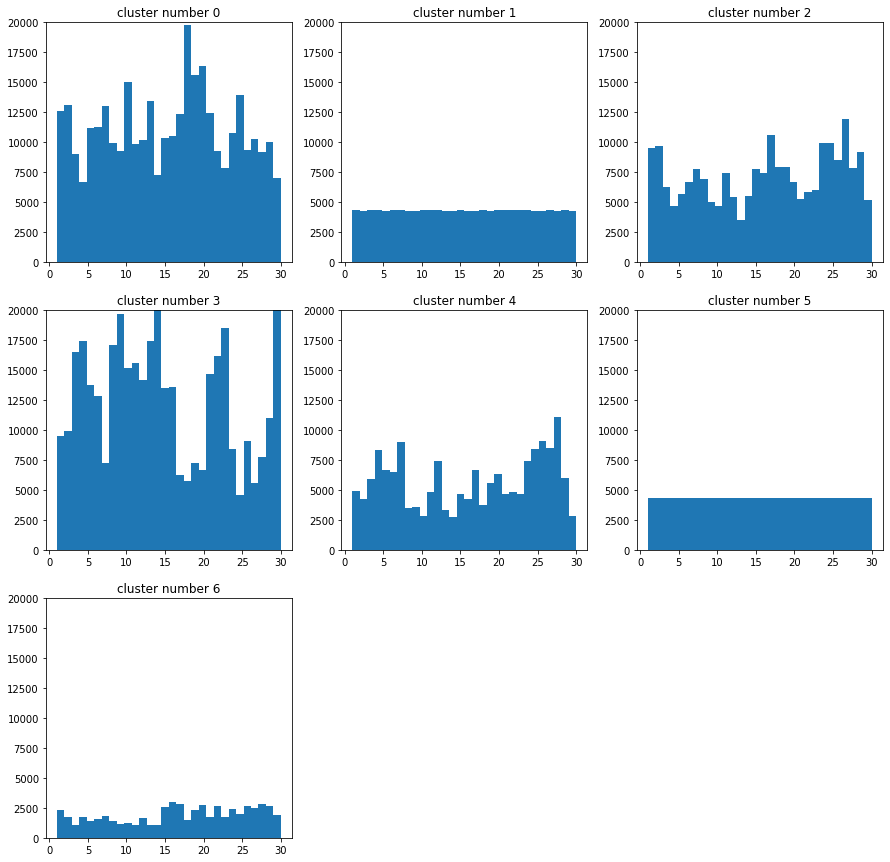

b'sonycnode-b827eb208550.sonyc'


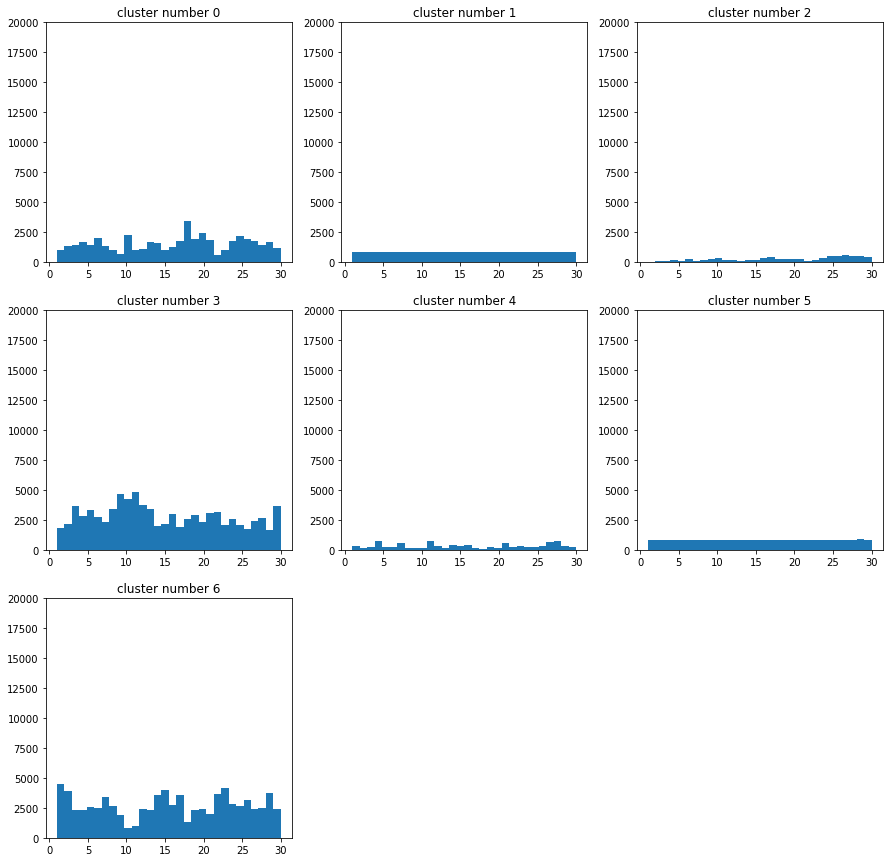

b'sonycnode-b827ebe3b72c.sonyc'


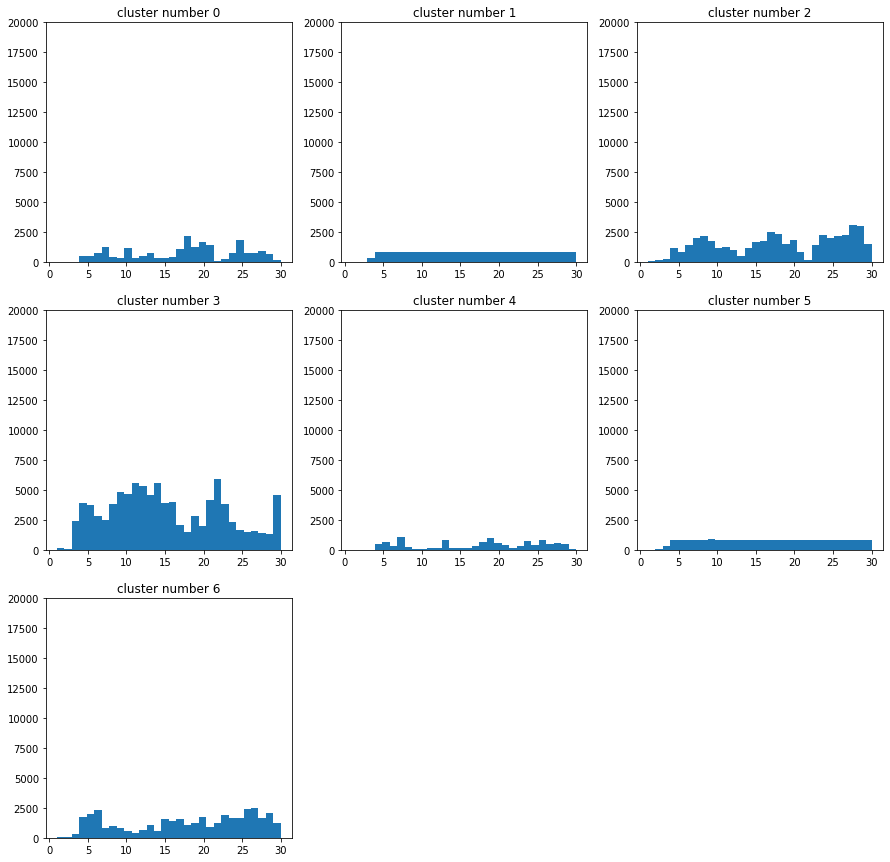

In [284]:
sensor_names = [b'sonycnode-b827eb491436.sonyc', b'sonycnode-b827ebc178d2.sonyc', b'sonycnode-b827eb208550.sonyc'
               , b'sonycnode-b827ebe3b72c.sonyc']
for name in sensor_names:
    sensor_mask = get_sensor_mask(d['sensor_id'], name)
    sensor_transformed = projected_45[sensor_mask]
    sensor_timestamps = d[sensor_mask, 'timestamp']
    sensor_timestamps_dt = convert_timestamps(sensor_timestamps)
    print(name)
    plot_clusters(7, sensor_transformed, projected_45[index], sensor_timestamps_dt)

# Making a dataframe with cluster numbers